In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer
from xverse.feature_subset import SplitXY
from xverse.transformer import WOE, MonotonicBinning

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('./data/train.csv', index_col=0)

### Review Continuous Variable

In [3]:
train_cont = train.select_dtypes(include=['float64'])

In [4]:
train_cont.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
id,,,,,,,,,,,,,,,
1,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
2,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
5,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
10,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
11,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [5]:
train_cont['loss'].describe()

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

In [6]:
train_cont[train_cont['loss'] < 10]

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
id,,,,,,,,,,,,,,,
173650,0.484469,0.785784,0.762059,0.452887,0.348388,0.711416,0.614204,0.34445,0.55855,0.69471,0.771508,0.758883,0.666708,0.313156,8.40
290635,0.645422,0.299102,0.527991,0.327354,0.422268,0.671307,0.464924,0.33906,0.62542,0.66076,0.607500,0.594646,0.678452,0.305218,5.25
320998,0.470002,0.555782,0.230975,0.652072,0.372405,0.489770,0.406628,0.93736,0.51050,0.43373,0.396226,0.387819,0.633362,0.434557,6.00
451870,0.425579,0.737068,0.673861,0.809278,0.551723,0.665573,0.579786,0.92176,0.48320,0.67065,0.685687,0.682413,0.633362,0.326923,0.67


Interesting to see that some claim payout is almost zero. It is in company benefits to automate those claims to save labor hours.

In [7]:
train_cont[train_cont['loss'] > 100000]

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
id,,,,,,,,,,,,,,,
167755,0.316554,0.620805,0.944251,0.259793,0.281143,0.398017,1.0,0.38885,0.30859,0.66572,0.985625,0.990604,0.129356,0.391758,121012.25
262556,0.316554,0.555782,0.944251,0.259793,0.281143,0.355523,1.0,0.38318,0.30859,0.66572,0.985625,0.990604,0.117810,0.382908,106863.00


Not statistically proven, cont attributes appear to converge to simliar values for very high loss claim amount. High values claim would worth audit from the claim department to ensure their accuracies.

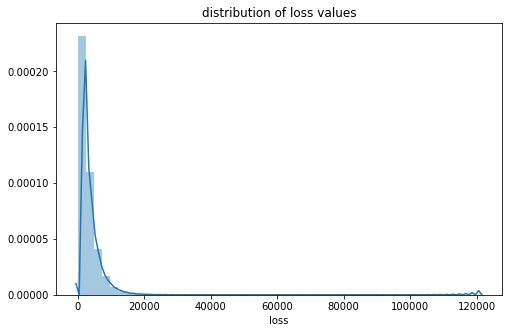

In [8]:
plt.figure(figsize=(8, 5))
sns.distplot(train_cont['loss'])
plt.title('distribution of loss values')
plt.show()

**Observation** : Distribution skew right, apply Power transformation to smoothen out the distribution.

In [9]:
train_cont['loss_train'] = PowerTransformer(
).fit_transform(train_cont[['loss']])

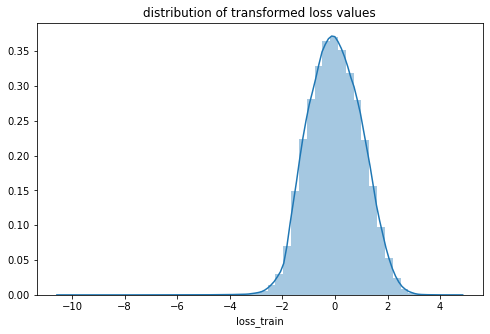

In [10]:
plt.figure(figsize=(8, 5))
sns.distplot(train_cont['loss_train'])
plt.title('distribution of transformed loss values')
plt.show()

We will apply Power

### Features Colinearity

Identify features that may not add power to the models.

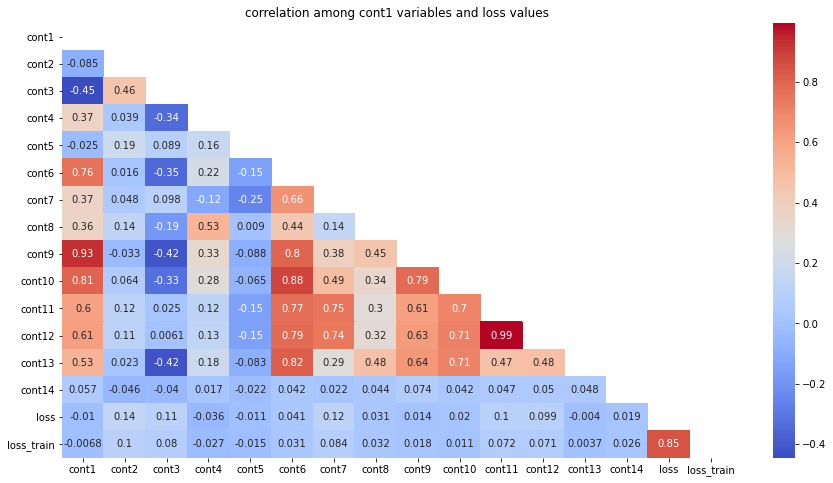

In [11]:
corr = train_cont.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True)
plt.title('correlation among cont1 variables and loss values');

Features collinearity (> 0.8)
- cont1 and cont9, cont10
- cont6 and cont9, cont10, cont13
- cont 11 and cont12

Drop features cont9, cont10, cont12, and cont13

In [12]:
train_df = train_cont.drop(['cont9', 'cont10', 'cont12', 'cont13'], axis=1)

In [13]:
train_df.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont11,cont14,loss,loss_train
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,1.883180e+05
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.493511,0.495717,3037.337686,1.766662e-15
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.209737,0.222488,2904.086186,1.000003e+00
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.035321,0.179722,0.670000,-1.029987e+01
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.310961,0.294610,1204.460000,-7.215512e-01
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.457203,0.407403,2115.570000,-1.805959e-02
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.678924,0.724623,3864.045000,7.163869e-01
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.998742,0.844848,121012.250000,4.579726e+00


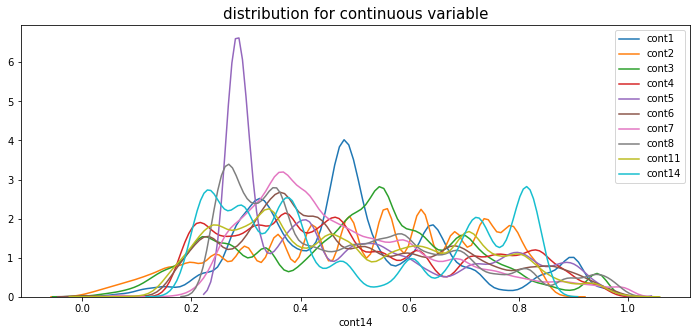

In [14]:
plt.figure(figsize=(12, 5))
for col in train_df.drop(['loss_train', 'loss'], axis=1):
    sns.distplot(train_df[col], hist=False, label=col)

plt.legend(loc='best')
plt.title('distribution for continuous variable', fontsize=15)
plt.show()

Values range between 0-1 for all continuous variables, they are likely represent probabilities.

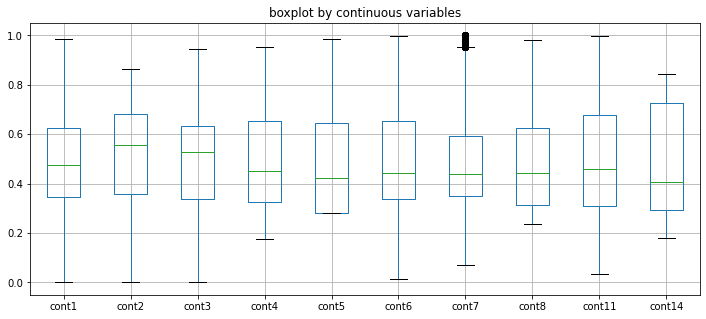

In [15]:
col_list = list(train_df.drop(['loss_train', 'loss'], axis=1).columns)
plt.figure(figsize=(12, 5))
train_df.boxplot(col_list)
plt.title('boxplot by continuous variables')
plt.show();

In [16]:
train_df.drop(['loss_train'], axis=1).to_csv('./data/num_df.csv', index=True)

### Review Categorical Variables

In [17]:
train_cat = train.select_dtypes(include=['O'])

In [18]:
train_cat.describe()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
count,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,8,7,8,7,5,7,5,8,7,5,16,15,19,9,13,17,20,17,20,11,84,131,16,51,61,19,23,326
top,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,C,E,C,A,P,F,A,A,A,E,E,G,F,B,BI,CL,A,E,BM,A,K,HK
freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,168186,159825,168851,186041,188284,181843,187009,187331,186510,188114,187905,188275,157445,181977,169969,177119,168250,180938,184593,184760,182980,187107,187361,187734,188105,156313,165729,169323,183393,180119,181177,186623,184110,172716,183991,187436,187617,188049,179127,137611,187071,179505,172949,183762,188173,188136,185296,188079,188018,187872,187596,188273,188239,188271,186056,179982,187626,188176,188011,188295,178646,118322,154275,184731,154307,181347,187503,186526,152929,137505,154385,147536,141534,154939,186005,103852,166992,168926,183744,177993,111028,124689,150237,121642,87531,174360,78127,105492,79455,42970,106721,177274,123737,42925,76493,47165,47310,65512,152918,25305,128395,25148,26191,131693,43866,21061


The categorical variables may represent the nature of the claims (e.g. fire, auto, flood) and have direct relationship the continuous variables. In that case, there could be collinearity among the categorical and numerics variables. Unfortunately, we don't know the definition of the variables hence we cannot draw direct inference on that. 

It is also difficult to analyze 116 features one by one. Instead, we will use recursive feature elimination (RFE) to narrow down variables based on feature importances

**Strategy**
1. Identify best machine learning algorithm based on continuous variables to obtain baseline performance
2. Add categorical variables and apply RFE to filter low power features
3. Fine tune models through hyperparameters tuning